# Sunglint Removal

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import rasterio
import sys

sys.path.append(r'C:\Users\sergi\Documents\repos\geopy\geopy')

import preprocessing.deglinting as deglinting
import reader
from image import Image
import plot

from enums import SENTINEL2_BANDS

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Data loading

In [3]:
filename = r"D:\UAVs\data\rasters\downsample\20230426_nan_average_downsampling_x5_y5.tif"

uav = reader.open(filename)
uav.rename({"Band 1": "Blue", "Band 2": "Green", "Band 3": "Red", "Band 4": "NIR"})

Bands: ['Blue', 'Green', 'Red', 'NIR', 'Band 5'] | Height: 2053 | Width: 2327

## Deep water area

### Load

In [4]:
shapes = gpd.read_file(r"D:\UAVs\data\shapefiles\deep_water\deep_water.shp").to_crs(uav.crs).geometry

deep_area_mask = rasterio.features.geometry_mask(geometries = shapes, 
                                                 out_shape = (uav.height, uav.width), 
                                                 transform = uav.transform, 
                                                 invert = True)

## Mask using hedley deglint

Text(0.5, 1.0, 'Hedley deglint')

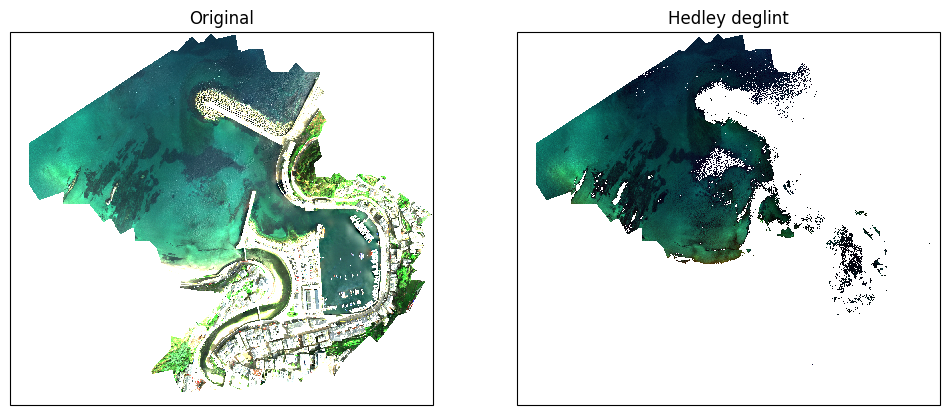

In [5]:
to_correct = uav.select(["Blue", "Green", "Red"])
nir_band = uav.select("NIR")

blue, green, red = deglinting.hedley(deep_area_mask, to_correct, nir_band)
for band, data in zip(["Deglint Blue", "Deglint Green", "Deglint Red"], [blue, green, red]):
    uav.add_band(band, data)


fig, axs = plot.get_geofigure(uav, 1, 2)
plot.plot_rgb(uav, 'Red', 'Green', 'Blue', ax=axs[0], brightness=15)
axs[0].set_title("Original")
plot.plot_rgb(uav, 'Deglint Red', 'Deglint Green', 'Deglint Blue', ax=axs[1], brightness=15)
axs[1].set_title("Hedley deglint")

## Mask using Lyzenga

Text(0.5, 1.0, 'Lyzenga deglint')

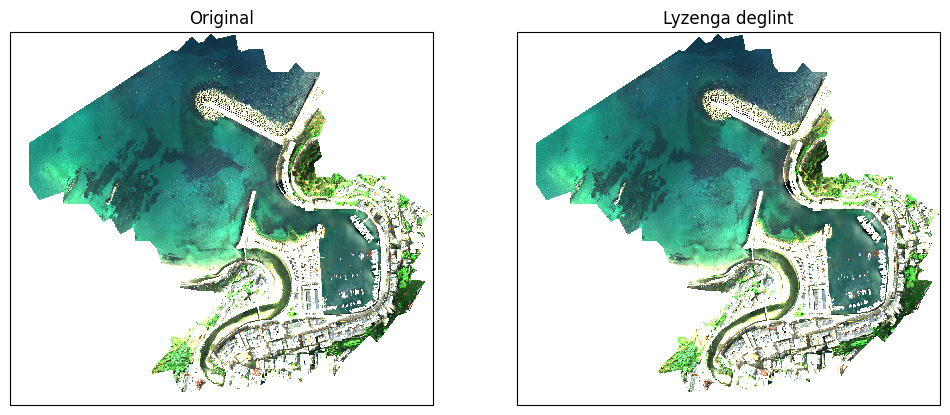

In [6]:
to_correct = uav.select(["Blue", "Green", "Red"])
nir_band = uav.select("NIR")

blue, green, red = deglinting.lyzenga(deep_area_mask, to_correct, nir_band)
for band, data in zip(["Deglint Blue", "Deglint Green", "Deglint Red"], [blue, green, red]):
    uav.add_band(band, data)


fig, axs = plot.get_geofigure(uav, 1, 2)
plot.plot_rgb(uav, 'Red', 'Green', 'Blue', ax=axs[0], brightness=15)
axs[0].set_title("Original")
plot.plot_rgb(uav, 'Deglint Red', 'Deglint Green', 'Deglint Blue', ax=axs[1], brightness=15)
axs[1].set_title("Lyzenga deglint")

## Mask using Joyce

Text(0.5, 1.0, 'Joyce deglint')

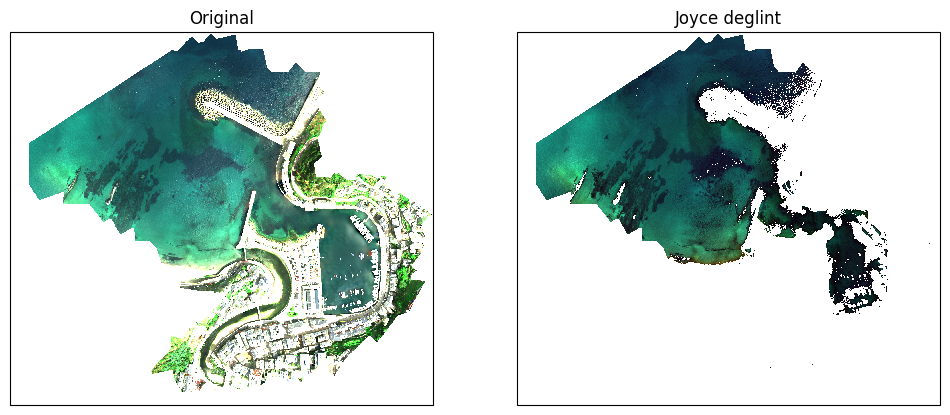

In [7]:
to_correct = uav.select(["Blue", "Green", "Red"])
nir_band = uav.select("NIR")

blue, green, red = deglinting.joyce(deep_area_mask, to_correct, nir_band)
for band, data in zip(["Deglint Blue", "Deglint Green", "Deglint Red"], [blue, green, red]):
    uav.add_band(band, data)


fig, axs = plot.get_geofigure(uav, 1, 2)
plot.plot_rgb(uav, 'Red', 'Green', 'Blue', ax=axs[0], brightness=15)
axs[0].set_title("Original")
plot.plot_rgb(uav, 'Deglint Red', 'Deglint Green', 'Deglint Blue', ax=axs[1], brightness=15)
axs[1].set_title("Joyce deglint")

## Extra: Using Satellite Images (Sentinel-2)

In [8]:
filename = r"D:\batimetria\cadiz\satelite\local_original\Pleamar\20240719_S2B_BDC_29SQA_L2W.nc"

satellite = reader.open(filename)
satellite.rename_by_enum(SENTINEL2_BANDS)
satellite.rename({'Rrs_B2': 'Blue', 'Rrs_B3': 'Green', 'Rrs_B4': 'Red', 'Rrs_B8': 'NIR'})
satellite.drop_bands( set(satellite.band_names).difference(['Blue', 'Green', 'Red', 'NIR']) )

Bands: ['Blue', 'Green', 'Red', 'NIR'] | Height: 2838 | Width: 2371

### Load Deep Area

In [9]:
shapes = gpd.read_file(r"D:\repos\geopy_usage\areas\cadiz_deep_water\cadiz_deep_water.shp").to_crs(satellite.crs).geometry

deep_area_mask = rasterio.features.geometry_mask(geometries = shapes, 
                                                 out_shape = (satellite.height, satellite.width), 
                                                 transform = satellite.transform, 
                                                 invert = True)

### All Methods

Text(0.5, 1.0, 'Joyce deglint')

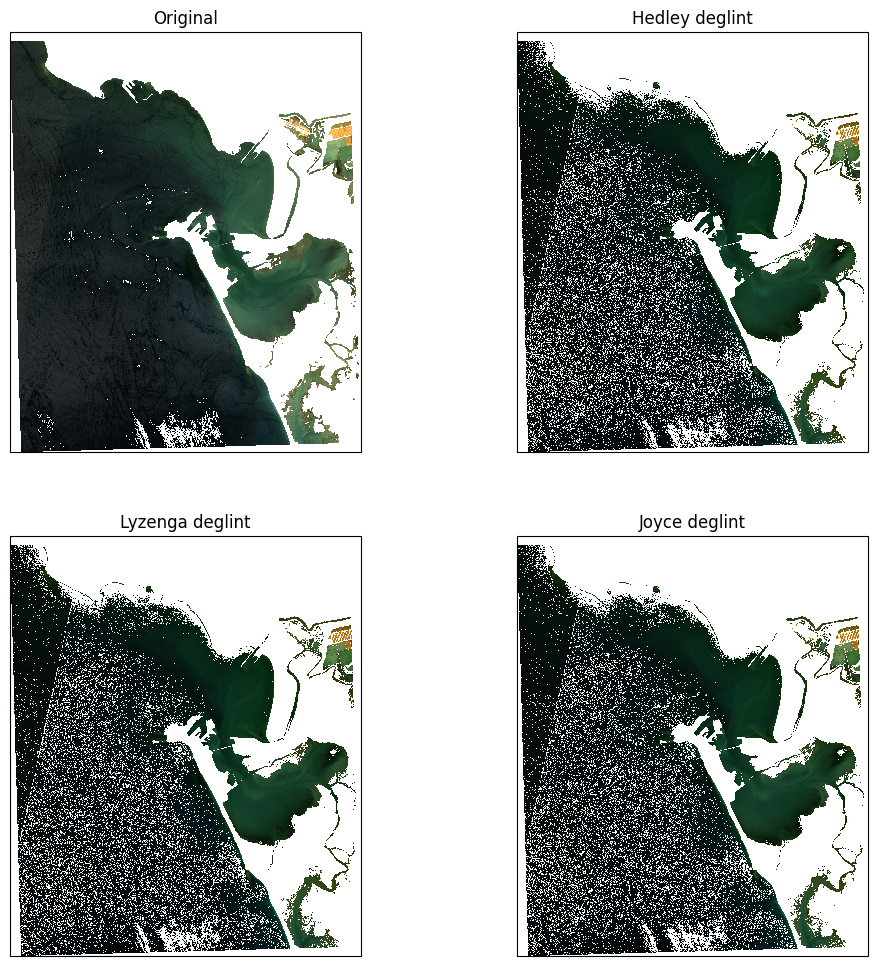

In [10]:
to_correct = satellite.select(["Blue", "Green", "Red"])
nir_band = satellite.select("NIR")

# Hedley deglinting
blue, green, red = deglinting.hedley(deep_area_mask, to_correct, nir_band)
for band, data in zip(["Hedley Blue", "Hedley Green", "Hedley Red"], [blue, green, red]):
    satellite.add_band(band, data)

# Lyzenga deglinting
blue, green, red = deglinting.lyzenga(deep_area_mask, to_correct, nir_band)
for band, data in zip(["Lyzenga Blue", "Lyzenga Green", "Lyzenga Red"], [blue, green, red]):
    satellite.add_band(band, data)

# Joyce deglinting
blue, green, red = deglinting.joyce(deep_area_mask, to_correct, nir_band)
for band, data in zip(["Joyce Blue", "Joyce Green", "Joyce Red"], [blue, green, red]):
    satellite.add_band(band, data)


fig, axs = plot.get_geofigure(satellite, 2, 2, figsize=(12, 12))
axs = axs.ravel()

plot.plot_rgb(satellite, 'Red', 'Green', 'Blue', ax=axs[0], brightness=15)
axs[0].set_title("Original")
plot.plot_rgb(satellite, 'Hedley Red', 'Hedley Green', 'Hedley Blue', ax=axs[1], brightness=15)
axs[1].set_title("Hedley deglint")
plot.plot_rgb(satellite, 'Lyzenga Red', 'Lyzenga Green', 'Lyzenga Blue', ax=axs[2], brightness=15)
axs[2].set_title("Lyzenga deglint")
plot.plot_rgb(satellite, 'Joyce Red', 'Joyce Green', 'Joyce Blue', ax=axs[3], brightness=15)
axs[3].set_title("Joyce deglint")